Link para o Vídeo: https://youtu.be/YjvNggnKF-A

## Módulos

In [ ]:
!pip install -q yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 11.1 MB/s eta 0:00:00


In [ ]:
#Cotações do Yahoo Finance
import yfinance as yf

# Tratamento de Dados
import pandas as pd
from pandas.tseries.offsets import BDay
pd.set_option("display.max_colwidth", 150)

#Gráficos
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

#Utilidades
from datetime import date

## Funções

In [ ]:
def busca_cadastro_cvm(data=(date.today()-BDay(2))):
  if data is not busca_cadastro_cvm.__defaults__[0]:
    data = pd.to_datetime(data)

  try:
    url = 'http://dados.cvm.gov.br/dados/FI/CAD/DADOS/cad_fi.csv'.format(data.year, data.month, data.day)
    return pd.read_csv(url, sep=';', encoding='ISO-8859-1')

  except:
    print("Arquivo {} não encontrado!".format(url))
    print("Forneça outra data!")

In [ ]:
def busca_informes_diarios_cvm_por_periodo(data_inicio, data_fim):
  datas = pd.date_range(data_inicio, data_fim, freq='MS')
  informe_completo = pd.DataFrame()

  for data in datas:
    try:
      url ='http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{}{:02d}.zip'.format(data.year, data.month)
      informe_mensal = pd.read_csv(url, sep=';')

    except:
      print("Arquivo {} não encontrado!".format(url))

    informe_completo = pd.concat([informe_completo, informe_mensal], ignore_index=True)

  return informe_completo

In [ ]:
def busca_informes_diarios_cvm_antes21(data_inicio, data_fim):
  datas = pd.date_range(data_inicio, data_fim)
  informe_completoh = pd.DataFrame()

  for data in datas:
    try:
      url ='https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/HIST/inf_diario_fi_{}.zip'.format(data.year)
      informe_mensalh = pd.read_csv(url, sep=';')


    except:
      print("Arquivo {} não encontrado!".format(url))

    informe_completoh = pd.concat([informe_completoh, informe_mensalh], ignore_index=True)
  return informe_completoh

In [ ]:
def melhores_e_piores(informes, cadastro, top=66, minimo_de_cotistas=33, classe=''):
  cadastro      = cadastro[cadastro['SIT'] == 'EM FUNCIONAMENTO NORMAL']
  fundos        = informes[informes['NR_COTST'] >= minimo_de_cotistas]
  cnpj_informes = fundos['CNPJ_FUNDO'].drop_duplicates()

  fundos = fundos.pivot_table(index='DT_COMPTC', columns='CNPJ_FUNDO')
  cotas_normalizadas = fundos['VL_QUOTA'] / fundos['VL_QUOTA'].iloc[0]

  if classe == 'multimercado':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo Multimercado']['CNPJ_FUNDO']
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'acoes':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo de Ações']['CNPJ_FUNDO']
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'rendafixa':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo de Renda Fixa']['CNPJ_FUNDO']
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'cambial':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo Cambial']['CNPJ_FUNDO']
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  #melhores
  melhores = pd.DataFrame()
  melhores['retorno(%)'] = (cotas_normalizadas.iloc[-1].sort_values(ascending=False)[:top] - 1) * 100
  for cnpj in melhores.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    melhores.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    melhores.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    melhores.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]

  #piores
  piores = pd.DataFrame()
  piores['retorno(%)'] = (cotas_normalizadas.iloc[-1].sort_values(ascending=True)[:top] - 1) * 100
  for cnpj in piores.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    piores.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    piores.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    piores.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]

  return melhores, piores

In [ ]:
def consulta_fundo(informes, cnpj):
  fundo = informes[informes['CNPJ_FUNDO'] == cnpj].copy()
  fundo.set_index('DT_COMPTC', inplace=True)
  fundo['cotas_normalizadas'] = (fundo['VL_QUOTA'] / fundo['VL_QUOTA'].iloc[0])*100
  return fundo

In [ ]:
def cdi_acumulado(data_inicio, data_fim):
  codigo_bcb = 12

  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  cdi = pd.read_json(url)
  cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
  cdi.set_index('data', inplace=True)

  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

In [ ]:
def selic_acumulada(data_inicio, data_fim):
  codigo_bcb = 4390

  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  selic = pd.read_json(url)
  selic['data'] = pd.to_datetime(selic['data'], dayfirst=True)
  selic.set_index('data', inplace=True)

  selic_acumulada = (1 + selic[data_inicio : data_fim] / 100).cumprod()
  selic_acumulada.iloc[0] = 1
  return selic_acumulada

## Benckmarks

In [ ]:
cdi = cdi_acumulado('2021-01-01', '2022-03-04') * 100
cdi

,valor
data,
2021-01-04,100.000000
2021-01-05,100.014939
2021-01-06,100.022409
2021-01-07,100.029879
2021-01-08,100.037351
...,...
2022-02-24,105.939944
2022-02-25,105.982498
2022-03-02,106.025069


In [ ]:
selic= selic_acumulada('2021-01-01', '2022-03-04') * 100
selic

,valor
data,
2021-01-01,100.000000
2021-02-01,100.280195
2021-03-01,100.480755
2021-04-01,100.691765
2021-05-01,100.963633
2021-06-01,101.276620
2021-07-01,101.641216
2021-08-01,102.078273
2021-09-01,102.527417


In [ ]:
ibov = yf.download('^BVSP', start='2021-01-01', end='2022-03-04')['Close']
ibov = (ibov / ibov.iloc[0])*100
ibov

[*********************100%***********************]  1 of 1 completed


Date
2021-01-04    100.000000
2021-01-05    100.560907
2021-01-06    101.090605
2021-01-07    102.866108
2021-01-08    105.498575
                 ...    
2022-02-23     94.475278
2022-02-24     94.124395
2022-02-25     95.431772
2022-03-02     97.145701
2022-03-03     97.138953
Name: Close, Length: 289, dtype: float64

## Buscando Dados da CVM

In [ ]:
cadastro = busca_cadastro_cvm()
cadastro

<ipython-input-15-949aebeb6514>:1: DtypeWarning: Columns (14,17,18,20,22,24,27,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  cadastro = busca_cadastro_cvm()


,TP_FUNDO,CNPJ_FUNDO,DENOM_SOCIAL,DT_REG,DT_CONST,CD_CVM,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_ATIV,...,ADMIN,PF_PJ_GESTOR,CPF_CNPJ_GESTOR,GESTOR,CNPJ_AUDITOR,AUDITOR,CNPJ_CUSTODIANTE,CUSTODIANTE,CNPJ_CONTROLADOR,CONTROLADOR
0,FACFIF,00.000.684/0001-21,DEUTSCHE BANK FDO APLIC QUOTAS FDO INV FINANCEIRO - MAX,2003-04-30,1994-12-20,19.0,2000-08-01,CANCELADA,2000-08-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FACFIF,00.000.731/0001-37,ITAMARITI CASH FUNDO APLICACAO QUOTAS FDOS INVESTIMENTO,2003-04-30,1994-05-18,40681.0,1996-01-26,CANCELADA,1996-01-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FACFIF,00.000.732/0001-81,FUNDO APLIC. QUOTAS DE F.I. SANTANDER CURTO PRAZO,2003-04-30,1994-05-24,27.0,1999-09-03,CANCELADA,1999-09-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FACFIF,00.000.740/0001-28,FUNDO DE APLIC EM QUOTAS DE FUNDOS DE INV BMC 60 DIAS URV,2003-04-30,1994-05-23,40690.0,1996-06-10,CANCELADA,1996-06-10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FACFIF,00.000.749/0001-39,BALANCE FUNDO APLICACAO QUOTAS FUNDO INVESTIMENTO FINANCEIRO,2003-04-30,1994-05-12,35.0,2000-06-26,CANCELADA,2000-06-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71091,FUNCINE,28.850.140/0001-78,FUNDO DE FINANCIAMENTO DA INDUSTRIA CINEMATOGRAFICA NACIONAL - FUNCINE - TIM,2017-10-16,2017-10-06,417001.0,NaN,EM FUNCIONAMENTO NORMAL,2017-12-26,2017-12-26,...,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,61.366.936/0001-25,ERNST & YOUNG AUDITORES INDEPENDENTES S/S LTDA.,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN
71092,FUNCINE,28.912.043/0001-62,HAPVIDA - FUNDO DE FINANCIAMENTO DA INDUSTRIA CINEMATOGRAFICA NACIONAL - FUNCINE,2017-10-27,2017-10-19,417003.0,NaN,EM FUNCIONAMENTO NORMAL,2018-12-21,2018-12-21,...,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,19.280.834/0001-26,NEXT AUDITORES INDEPENDENTES S/S LTDA.,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN
71093,FUNCINE,31.674.280/0001-47,MEDIA VENTURE ESG INCENTIVADO - FUNDO DE FINANCIAMENTO DA INDUSTRIA CINEMATOGRAFICA NACIONAL,2018-10-26,2018-09-13,418001.0,NaN,EM FUNCIONAMENTO NORMAL,2022-12-26,2022-12-26,...,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,16.549.480/0001-84,RSM BRASIL AUDITORES INDEPENDENTES - SOCIEDADE SIMPLES,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN
71094,FUNCINE,32.222.962/0001-81,Fundo de Financiamento da Indústria Cinematográfica Nacional de Minas Gerais,2018-12-20,2018-11-14,418002.0,2021-10-29,CANCELADA,2021-10-29,NaN,...,INTRADER DTVM LTDA,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES LTDA.,15.489.568/0001-95,INTRADER DTVM LTDA,NaN,NaN


In [ ]:
#informe_hi = busca_informes_diarios_cvm_antes21(data_inicio='2013', data_fim='2020')
#informe_hi


In [ ]:
informes = busca_informes_diarios_cvm_por_periodo(data_inicio='2021-01', data_fim='2022-03')
informes

,TP_FUNDO,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
0,FI,00.017.024/0001-53,2021-01-04,1097664.87,27.503336,1095773.57,0.0,0.0,1
1,FI,00.017.024/0001-53,2021-01-05,1097742.61,27.503455,1095778.31,0.0,0.0,1
2,FI,00.017.024/0001-53,2021-01-06,1097837.04,27.503196,1095768.02,0.0,0.0,1
3,FI,00.017.024/0001-53,2021-01-07,1097939.54,27.503352,1095774.20,0.0,0.0,1
4,FI,00.017.024/0001-53,2021-01-08,1096790.38,27.503710,1095788.49,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
6736163,FI,97.929.213/0001-34,2022-03-25,72973880.29,9.601337,72963645.88,0.0,0.0,2
6736164,FI,97.929.213/0001-34,2022-03-28,73011911.38,9.606289,73001275.99,0.0,0.0,2
6736165,FI,97.929.213/0001-34,2022-03-29,72973008.18,9.604625,72988633.14,0.0,0.0,2
6736166,FI,97.929.213/0001-34,2022-03-30,72867250.91,9.587158,72855897.94,0.0,0.0,2


#Filtro FundoTCE

In [ ]:
austro= informes.loc[informes['CNPJ_FUNDO']=='18.366.002/0001-64']

In [ ]:
austro

,TP_FUNDO,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
140354,FI,18.366.002/0001-64,2021-01-04,86206440.26,1.373842,80468738.42,0.0,0.00,33
140355,FI,18.366.002/0001-64,2021-01-05,86200504.38,1.373650,80457480.95,0.0,0.00,33
140356,FI,18.366.002/0001-64,2021-01-06,86194568.85,1.373458,80446224.55,0.0,0.00,33
140357,FI,18.366.002/0001-64,2021-01-07,86188633.70,1.373266,80434969.25,0.0,0.00,33
140358,FI,18.366.002/0001-64,2021-01-08,86182698.91,1.373073,80423715.04,0.0,0.00,33
...,...,...,...,...,...,...,...,...,...
5916457,FI,18.366.002/0001-64,2022-02-25,15473390.59,0.970290,8555747.25,0.0,0.00,33
6373370,FI,18.366.002/0001-64,2022-03-02,15473390.59,0.970195,8554910.72,0.0,0.00,33
6373371,FI,18.366.002/0001-64,2022-03-03,15473390.59,0.970100,8554074.24,0.0,0.00,33
6373372,FI,18.366.002/0001-64,2022-03-04,0.00,0.970005,0.00,0.0,8553237.87,0


#FUNDOS MULTIMERCADO

In [ ]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe='multimercado')


In [ ]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
37.927.641/0001-04,77.617680,BTG PACTUAL ECONOMIA REAL FEEDER I FUNDO DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,2.376503e+08
27.945.399/0001-30,77.379228,CRESCERA GROWTH ADVISORY FUNDO DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,8.048803e+07
37.681.227/0001-50,77.318106,BTG PACTUAL ECONOMIA REAL FEEDER FI EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,1.409063e+08
37.660.648/0001-02,74.051584,WARREN ORÁCULO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO - CRED PRIV,Fundo Multimercado,1.529342e+07
21.646.715/0001-96,60.506697,VISTA MULTIESTRATÉGIA FUNDO DE INVESTIMENTO EM COTAS DE FUNDO DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,6.660572e+08


In [ ]:
piores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
30.282.418/0001-08,-61.495724,STARBOARD SPECIAL SITUATIONS II ADVISORY FIC FIM - CP,Fundo Multimercado,20388124.12
18.602.683/0001-12,-50.310443,FUNDO DE INVESTIMENTO EM COTAS DE FI MULTIMERCADO BRASIL NORDESTE DESENVOLVIMENTO IMOBILIÁRIO,Fundo Multimercado,22737417.95
13.088.603/0001-39,-50.204106,CSHG DELTA ENERGIA - FUNDO DE INVESTIMENTO MULTIMERCADO CRÉDITO PRIVADO LONGO PRAZO,Fundo Multimercado,16028788.18
28.254.554/0001-34,-50.009530,GESTÃO RECEBÍVEIS DE ENERGIA FI EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO CRÉDITO PRIVADO,Fundo Multimercado,1265151.40
34.218.748/0001-87,-48.923190,VITREO CANNABIS ATIVO FUNDO DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,10187627.10


In [ ]:
austro2= cadastro.loc[cadastro['CNPJ_FUNDO']=='18.366.002/0001-64']

In [ ]:
austro2

,TP_FUNDO,CNPJ_FUNDO,DENOM_SOCIAL,DT_REG,DT_CONST,CD_CVM,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_ATIV,...,ADMIN,PF_PJ_GESTOR,CPF_CNPJ_GESTOR,GESTOR,CNPJ_AUDITOR,AUDITOR,CNPJ_CUSTODIANTE,CUSTODIANTE,CNPJ_CONTROLADOR,CONTROLADOR
27385,FI,18.366.002/0001-64,AUSTRO MULTIPAR FUNDO DE INVESTIMENTO EM COTA DE FUNDOS DE INVESTIMENTO MULTIMERCADO CRÉDITO PRIVADO,2013-07-03,2013-06-18,208418.0,2022-03-04,CANCELADA,2022-03-04,2013-08-06,...,BFL ADMINISTRADORA DE RECURSOS,PJ,12.678.380/0001-05,VCM GESTÃO DE CAPITAL LTDA,19.280.834/0001-26,NEXT AUDITORES INDEPENDENTES S/S LTDA.,03.751.794/0001-13,TERRA INVESTIMENTOS DISTRIBUIDORA DE TITULOS E VALORES MOBILIARIOS LTDA,03.751.794/0001-13,TERRA INVESTIMENTOS DISTRIBUIDORA DE TITULOS E VALORES MOBILIARIOS LTDA


#exporta para excell

In [ ]:
piores.to_excel(r'C:\Users\Felipe\Desktop\export_dataframe.xlsx', index=False)

#Gráfico

In [ ]:
cotas = pd.DataFrame()
fundos_destaque = piores

for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [ ]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=ibov.index, y=ibov, name='IBOV', line=dict(color='black', width=3)))

fig.add_traces(traces)
fig.update_layout(title='Piores Fundos multimercado')
fig.update_layout(legend_orientation="h")

fig.show()

## Fundos de Ações

In [ ]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe='acoes')

In [ ]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
36.327.455/0001-63,53.057180,TREND BOLSA AMERICANA ALAVANCADO FUNDO DE INVESTIMENTO EM AÇÕES,Fundo de Ações,4.916206e+07
29.177.024/0001-00,48.750040,TRIGONO DELPHOS INCOME FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM ACOES,Fundo de Ações,4.396979e+08
03.917.778/0001-58,42.485824,ITAÚ AÇÕES PETROBRÁS - FUNDO DE INVESTIMENTO,Fundo de Ações,2.760877e+08
29.177.013/0001-12,42.059053,TRIGONO FLAGSHIP SMALL CAPS FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM ACOES,Fundo de Ações,2.190404e+08
03.914.671/0001-56,41.427907,FUNDO DE INVESTIMENTO EM AÇÕES CAIXA PETROBRAS,Fundo de Ações,6.706648e+08


In [ ]:
piores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
13.199.100/0001-30,-72.955896,SANTANDER FUNDO DE INVESTIMENTO COLABORADORES MAGAZINE LUIZA AÇÕES,Fundo de Ações,5461796.42
13.476.201/0001-01,-49.471803,FATOR SINERGIA FUNDO DE INVESTIMENTO EM AÇÕES,Fundo de Ações,6867039.56
34.218.661/0001-00,-46.868807,VITREO CANABIDIOL FUNDO DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR,Fundo de Ações,29873896.08
47.177.431/0001-91,-39.650478,ALFA - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES,Fundo de Ações,2738688.46
24.874.367/0001-00,-37.364311,INTER + IBOVESPA ATIVO FUNDO DE INVESTIMENTO EM AÇÕES,Fundo de Ações,33137991.73


### Graficos

In [ ]:
cotas = pd.DataFrame()
fundos_destaque = pd.concat([melhores, piores])

for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [ ]:
cotas

Fundo de Investimento,TREND BOLSA AMERICANA ALAVANCADO FUNDO DE INVESTIMENTO EM AÇÕES,TRIGONO DELPHOS INCOME FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM ACOES,ITAÚ AÇÕES PETROBRÁS - FUNDO DE INVESTIMENTO,TRIGONO FLAGSHIP SMALL CAPS FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM ACOES,FUNDO DE INVESTIMENTO EM AÇÕES CAIXA PETROBRAS,SANTANDER FUNDO DE INVESTIMENTO COLABORADORES MAGAZINE LUIZA AÇÕES,FATOR SINERGIA FUNDO DE INVESTIMENTO EM AÇÕES,VITREO CANABIDIOL FUNDO DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR,ALFA - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES,INTER + IBOVESPA ATIVO FUNDO DE INVESTIMENTO EM AÇÕES
2021-01-04,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2021-01-05,101.378680,100.497042,103.044585,100.555729,103.037603,98.256501,99.547414,103.153722,100.306108,100.422139
2021-01-06,103.221351,101.660324,104.057359,101.290333,104.045668,93.028790,96.746187,109.798394,99.610257,98.330462
2021-01-07,105.610775,104.295463,107.271083,103.545521,107.252857,91.918873,95.331766,114.862994,101.892324,102.271979
2021-01-08,106.378456,105.948092,107.064323,105.509296,107.043875,94.610275,97.420692,116.081614,104.153581,107.805198
...,...,...,...,...,...,...,...,...,...,...
2022-03-25,152.827614,149.578346,141.534032,142.586767,140.508906,25.938366,49.675346,53.986165,60.527674,64.131315
2022-03-28,154.933135,148.864905,137.812883,142.247662,136.805482,25.661889,49.319138,52.646115,60.527357,62.859432
2022-03-29,158.819543,150.390324,139.505307,144.396783,138.479467,27.754124,51.331605,53.833907,61.063959,66.734738
2022-03-30,157.251446,149.226902,141.965118,142.982243,140.915457,27.241482,50.714235,53.731780,60.712737,64.966388


In [ ]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=ibov.index, y=ibov, name='IBOV', line=dict(color='black', width=3)))

fig.add_traces(traces)
fig.update_layout(title='Melhores e Piores Fundos de Ações do 1º Semestre de 2022')
fig.update_layout(legend_orientation="h")

fig.show()

## Fundos Cambiais


In [ ]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe='cambial')

In [ ]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
32.246.789/0001-51,20.699835,TREND SHORT DOLAR FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,1.570204e+07
20.077.065/0001-42,-6.992345,MAPFRE FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,1.340165e+07
04.061.044/0001-82,-8.237853,BB CAMBIAL DÓLAR LP VIP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo Cambial,5.346205e+08
04.128.893/0001-06,-8.457377,BB CAMBIAL DOLAR LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo Cambial,2.817194e+08
33.144.687/0001-98,-8.855688,BTG PACTUAL DIGITAL DOLAR FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,2.793502e+08


In [ ]:
piores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
04.305.193/0001-40,-18.651353,BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo Cambial,83871195.82
37.569.678/0001-08,-15.867292,VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,17272873.58
00.819.855/0001-49,-12.340895,WESTERN ASSET CÂMBIO DOLAR SILVER FICFI CAMBIAL,Fundo Cambial,1046640.54
01.171.956/0001-19,-12.143966,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR,Fundo Cambial,5466018.63
05.495.393/0001-75,-10.679392,SAFRA CAMBIAL SUPER - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL,Fundo Cambial,10962687.91


### Grafico de Cotas

In [ ]:
cotas = pd.DataFrame()
fundos_destaque =  pd.concat([melhores, piores])

for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [ ]:
cotas

Fundo de Investimento,TREND SHORT DOLAR FUNDO DE INVESTIMENTO CAMBIAL,MAPFRE FUNDO DE INVESTIMENTO CAMBIAL,BB CAMBIAL DÓLAR LP VIP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BB CAMBIAL DOLAR LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BTG PACTUAL DIGITAL DOLAR FUNDO DE INVESTIMENTO CAMBIAL,BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL,WESTERN ASSET CÂMBIO DOLAR SILVER FICFI CAMBIAL,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR,SAFRA CAMBIAL SUPER - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL
2021-01-04,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2021-01-05,99.679415,100.322822,100.369457,100.368638,100.341475,102.459595,100.830407,100.317738,100.326317,100.324703
2021-01-06,99.825633,100.201594,100.242649,100.240899,100.216021,102.612523,100.693730,100.181100,100.186851,100.192022
2021-01-07,97.285640,102.636634,102.806850,102.804374,102.796777,103.211369,102.573487,102.685613,102.749018,102.711749
2021-01-08,96.693660,103.250873,103.449137,103.445874,103.449751,103.605218,103.111924,103.300614,103.386335,103.341973
...,...,...,...,...,...,...,...,...,...,...
2022-03-25,120.408840,92.934995,91.673822,91.457377,91.087966,81.392992,83.797791,87.661199,87.846151,89.285040
2022-03-28,120.076107,93.258293,92.009840,91.792056,91.417976,81.401579,83.631446,87.780478,88.151551,89.595841
2022-03-29,120.306701,93.163172,91.914525,91.696201,91.317329,81.645045,83.895949,87.845613,88.042204,89.493071
2022-03-30,120.165848,93.331929,92.085864,91.866374,91.486576,82.086720,84.463930,87.990072,88.194194,89.655409


In [ ]:
cotas

Fundo de Investimento,TREND SHORT DOLAR FUNDO DE INVESTIMENTO CAMBIAL,MAPFRE FUNDO DE INVESTIMENTO CAMBIAL,BB CAMBIAL DÓLAR LP VIP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BB CAMBIAL DOLAR LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BTG PACTUAL DIGITAL DOLAR FUNDO DE INVESTIMENTO CAMBIAL,BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL,WESTERN ASSET CÂMBIO DOLAR SILVER FICFI CAMBIAL,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR,SAFRA CAMBIAL SUPER - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL
2021-01-04,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2021-01-05,99.679415,100.322822,100.369457,100.368638,100.341475,102.459595,100.830407,100.317738,100.326317,100.324703
2021-01-06,99.825633,100.201594,100.242649,100.240899,100.216021,102.612523,100.693730,100.181100,100.186851,100.192022
2021-01-07,97.285640,102.636634,102.806850,102.804374,102.796777,103.211369,102.573487,102.685613,102.749018,102.711749
2021-01-08,96.693660,103.250873,103.449137,103.445874,103.449751,103.605218,103.111924,103.300614,103.386335,103.341973
...,...,...,...,...,...,...,...,...,...,...
2022-03-25,120.408840,92.934995,91.673822,91.457377,91.087966,81.392992,83.797791,87.661199,87.846151,89.285040
2022-03-28,120.076107,93.258293,92.009840,91.792056,91.417976,81.401579,83.631446,87.780478,88.151551,89.595841
2022-03-29,120.306701,93.163172,91.914525,91.696201,91.317329,81.645045,83.895949,87.845613,88.042204,89.493071
2022-03-30,120.165848,93.331929,92.085864,91.866374,91.486576,82.086720,84.463930,87.990072,88.194194,89.655409


In [ ]:
ibov

Date
2021-01-04    100.000000
2021-01-05    100.560907
2021-01-06    101.090605
2021-01-07    102.866108
2021-01-08    105.498575
                 ...    
2022-02-23     94.475278
2022-02-24     94.124395
2022-02-25     95.431772
2022-03-02     97.145701
2022-03-03     97.138953
Name: Close, Length: 289, dtype: float64

In [ ]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=ibov.index, y=ibov, name='IBOV', line=dict(color='black', width=3)))

fig.add_traces(traces)
fig.update_layout(title='Melhores Fundos Cambiais do 1º Semestre de 2022')
fig.update_layout(legend_orientation="h")

fig.show()

In [ ]:
cotas.columns

Index(['TREND SHORT DOLAR FUNDO DE INVESTIMENTO CAMBIAL',
       'MAPFRE FUNDO DE INVESTIMENTO CAMBIAL',
       'BB CAMBIAL DÓLAR LP VIP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO',
       'BB CAMBIAL DOLAR LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO',
       'BTG PACTUAL DIGITAL DOLAR FUNDO DE INVESTIMENTO CAMBIAL',
       'BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO',
       'VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL',
       'WESTERN ASSET CÂMBIO DOLAR SILVER FICFI CAMBIAL',
       'BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR',
       'SAFRA CAMBIAL SUPER - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL'],
      dtype='object', name='Fundo de Investimento')

### Correlação

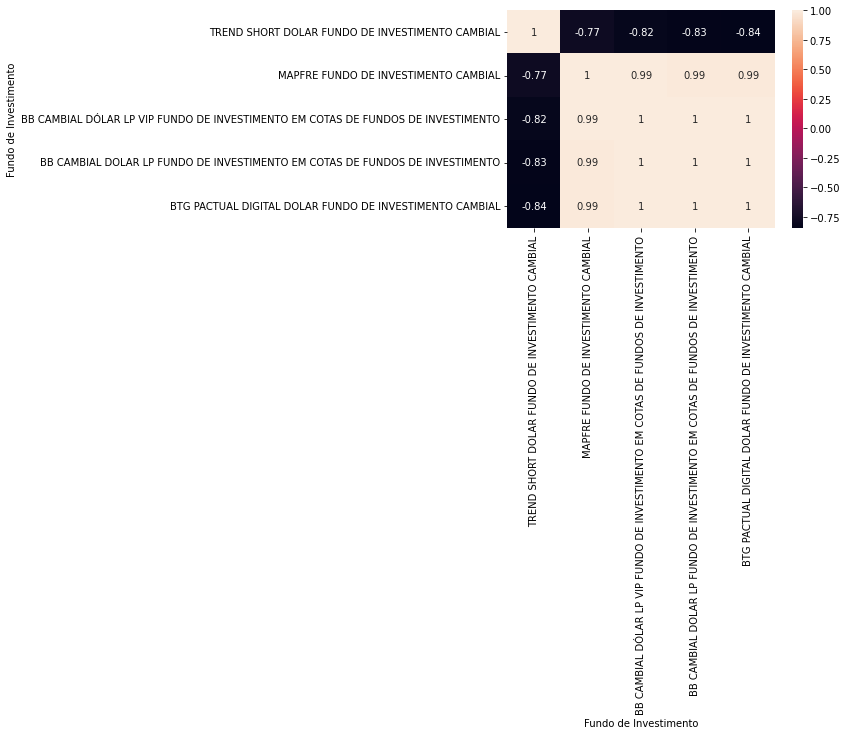

In [ ]:
sns.heatmap(cotas.iloc[:, :5].corr(), annot=True);

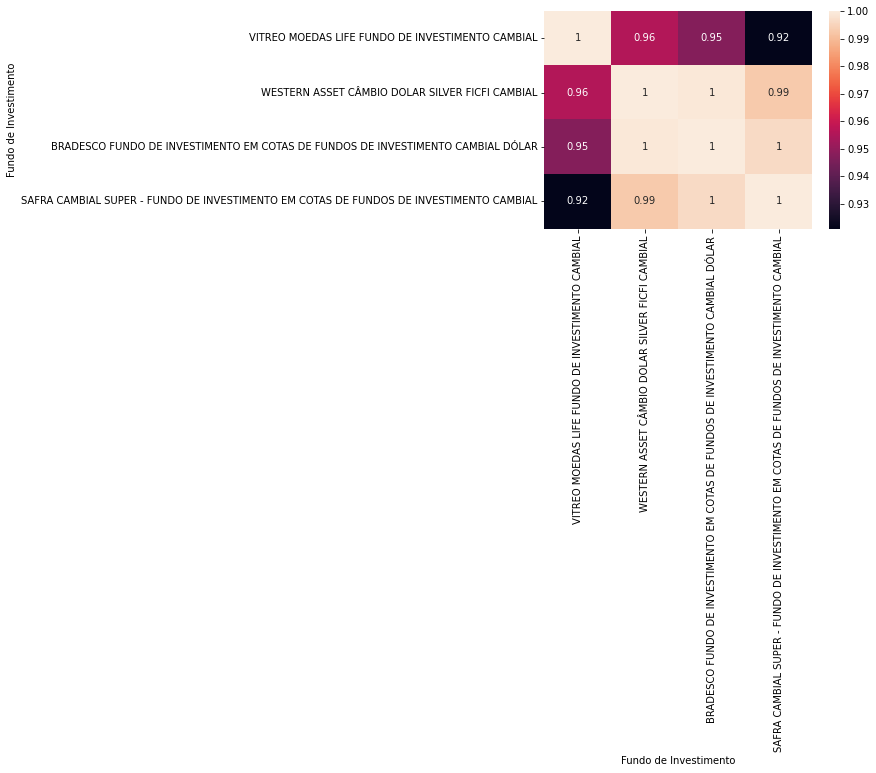

In [ ]:
sns.heatmap(cotas.iloc[:, 6:].corr(), annot=True);